## Dogs vs Cats

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /content/cats_and_dogs_filtered.zip

--2021-08-01 16:15:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   104MB/s    in 0.6s    

2021-08-01 16:15:07 (104 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> validation -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [4]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.289.jpg', 'cat.275.jpg', 'cat.168.jpg', 'cat.902.jpg', 'cat.660.jpg', 'cat.339.jpg', 'cat.628.jpg', 'cat.595.jpg', 'cat.140.jpg', 'cat.990.jpg']
['dog.12.jpg', 'dog.39.jpg', 'dog.42.jpg', 'dog.210.jpg', 'dog.228.jpg', 'dog.839.jpg', 'dog.369.jpg', 'dog.723.jpg', 'dog.305.jpg', 'dog.646.jpg']


In [6]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [8]:
# RMS is preferrable to SGD because RMSprop automates learning-rate tuning for us
# Adam, AdaGrad will also do good

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# rescale all images by 1./255.
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,                    # steps_per_epoch = total training records / batch size = 2000/20
                    epochs=50,
                    validation_steps=50,                    # validation_steps = total validation records / batch size = 1000/20
                    verbose=2)

Epoch 1/50
100/100 - 19s - loss: 0.7954 - accuracy: 0.5325 - val_loss: 0.6816 - val_accuracy: 0.5020
Epoch 2/50
100/100 - 17s - loss: 0.6804 - accuracy: 0.5805 - val_loss: 0.6201 - val_accuracy: 0.6530
Epoch 3/50
100/100 - 18s - loss: 0.6502 - accuracy: 0.6180 - val_loss: 0.6060 - val_accuracy: 0.6530
Epoch 4/50
100/100 - 17s - loss: 0.6321 - accuracy: 0.6415 - val_loss: 0.6055 - val_accuracy: 0.6670
Epoch 5/50
100/100 - 18s - loss: 0.6356 - accuracy: 0.6600 - val_loss: 0.5809 - val_accuracy: 0.7060
Epoch 6/50
100/100 - 17s - loss: 0.6196 - accuracy: 0.6585 - val_loss: 0.5783 - val_accuracy: 0.7150
Epoch 7/50
100/100 - 17s - loss: 0.6546 - accuracy: 0.6555 - val_loss: 0.5917 - val_accuracy: 0.6980
Epoch 8/50
100/100 - 17s - loss: 0.6094 - accuracy: 0.6830 - val_loss: 0.5847 - val_accuracy: 0.7000
Epoch 9/50
100/100 - 17s - loss: 0.5953 - accuracy: 0.6895 - val_loss: 0.5678 - val_accuracy: 0.7070
Epoch 10/50
100/100 - 16s - loss: 0.5920 - accuracy: 0.6925 - val_loss: 0.5277 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

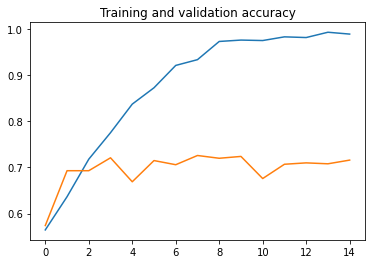

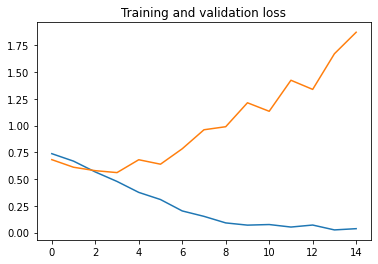

In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss')

In [ ]:
# load image to test

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving cat.jfif to cat.jfif
[0.]
cat.jfif is a cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


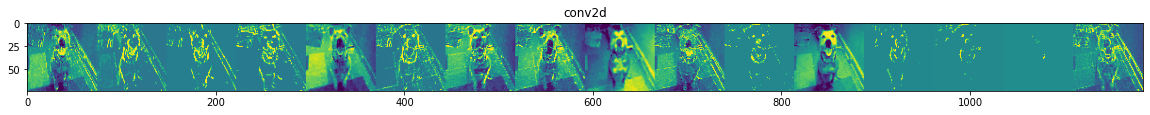

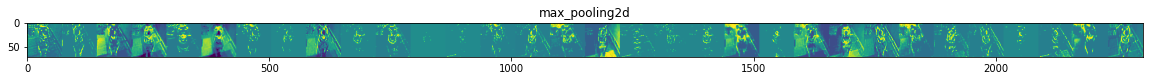

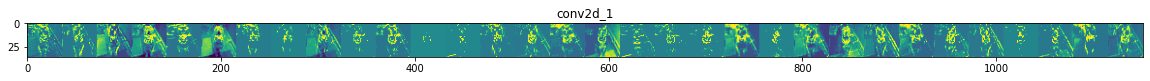

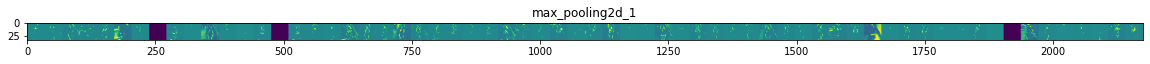

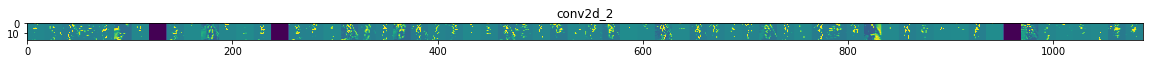

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
# to terminate the kernel and free memory resources

import os, signal
os.kill(os.getpid(), signal.SIGKILL)

## Dogs vs Cats on bigger dataset

**Exercise 5**

In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

--2021-07-28 13:49:16--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.52.129, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.36.52.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   187MB/s    in 4.4s    

2021-07-28 13:49:21 (181 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
import os
import zipfile

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# content -> PetImages -> cats, dogs
# training and validation directory not given separately

print(len(os.listdir('/content/PetImages/Cat/')))
print(len(os.listdir('/content/PetImages/Dog/')))

12501
12501


In [ ]:
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/testing')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/testing/cats')
    os.mkdir('/content/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
# it will split the directory and separate train and validation images
# 90% images will be copied to training folder
# 10% to validation

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [ ]:
CAT_SOURCE_DIR = "/content/PetImages/Cat/"
TRAINING_CATS_DIR = "/content/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/content/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"
TRAINING_DOGS_DIR = "/content/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/content/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [ ]:
print(len(os.listdir('/content/cats-v-dogs/training/cats/')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/content/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/content/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/10
179/225 [======================>.......] - ETA: 14s - loss: 0.7334 - accuracy: 0.6217

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 79s 347ms/step - loss: 0.7044 - accuracy: 0.6362 - val_loss: 0.5366 - val_accuracy: 0.7316
Epoch 2/10
225/225 [==============================] - 76s 339ms/step - loss: 0.5165 - accuracy: 0.7424 - val_loss: 0.4591 - val_accuracy: 0.7744
Epoch 3/10
225/225 [==============================] - 76s 336ms/step - loss: 0.4368 - accuracy: 0.7974 - val_loss: 0.4352 - val_accuracy: 0.7940
Epoch 4/10
225/225 [==============================] - 76s 339ms/step - loss: 0.3717 - accuracy: 0.8331 - val_loss: 0.4415 - val_accuracy: 0.7976
Epoch 5/10
225/225 [==============================] - 76s 337ms/step - loss: 0.3021 - accuracy: 0.8691 - val_loss: 0.4181 - val_accuracy: 0.8196
Epoch 6/10
225/225 [==============================] - 76s 338ms/step - loss: 0.2325 - accuracy: 0.9048 - val_loss: 0.6604 - val_accuracy: 0.7260
Epoch 7/10
225/225 [==============================] - 75s 333ms/step - loss: 0.1598 - accuracy: 0.9383 - val_loss: 0.6033 - val_accuracy: 0.7

<Figure size 432x288 with 0 Axes>

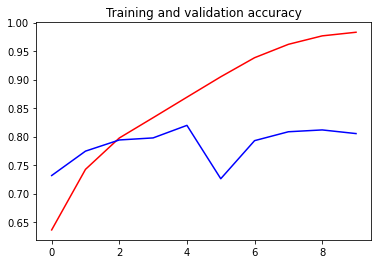

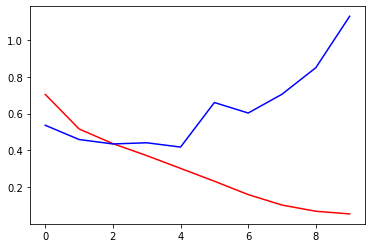

<Figure size 432x288 with 0 Axes>

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.figure()

In [ ]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat.jpg to cat.jpg
[0.]
cat.jpg is a cat
